In [26]:
#import library
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Set device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device} (GPU: {torch.cuda.is_available()})")

Using device: cuda (GPU: True)


In [28]:
#Config parameters
data_dir = 'data_split'
train_dir = ('data_split/train')
test_dir = ('data_split/test')
val_dir = ('data_split/val')

batch_size = 16
num_classes = 3
Epochs = 100
img_size = (256, 256)

In [29]:
### Data Augmentation ###
from torchvision import transforms


# Advanced ************************************
# Enhancement Data Augmentation
transforms_train = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(30),
    transforms.ColorJitter(
        brightness=0.3, 
        contrast=0.3, 
        saturation=0.3, 
        hue=0.1
    ),
    transforms.RandomAffine(
        degrees=15, 
        translate=(0.15, 0.15), 
        scale=(0.8, 1.2)
    ),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transforms_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transforms_val)
test_dataset = datasets.ImageFolder(test_dir, transform=transforms_val)

# Print dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}
print(f"Dataset sizes: {dataset_sizes}")

#Compress data
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2,)   
}

Dataset sizes: {'train': 546, 'val': 117, 'test': 118}


In [30]:
### K-Fold Cross-Validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Training fold {fold+1}")
    # Create fold-specific datasets and dataloaders
    # Train model
    # Store results

Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5


Batch Shape: torch.Size([16, 3, 256, 256])
Data Type: torch.float32
Min: -2.1179039478302, Max: 2.640000104904175
Mean: -1.0387, Std: 0.9054
Number of batches in each split:
- Train: 35
- Val: 8
- Test: 8
Class to Index Mapping:
{'benign': 0, 'malignant': 1, 'normal': 2}

Class Names (in order of indices):
['benign', 'malignant', 'normal']

Samples per class:
benign: 306 images
malignant: 147 images
normal: 93 images
Image stats - Min: 0.000, Max: 0.879, Mean: 0.213
Image stats - Min: 0.000, Max: 0.801, Mean: 0.096
Image stats - Min: 0.000, Max: 0.930, Mean: 0.303
Image stats - Min: 0.000, Max: 1.000, Mean: 0.306
Image stats - Min: 0.000, Max: 0.576, Mean: 0.144


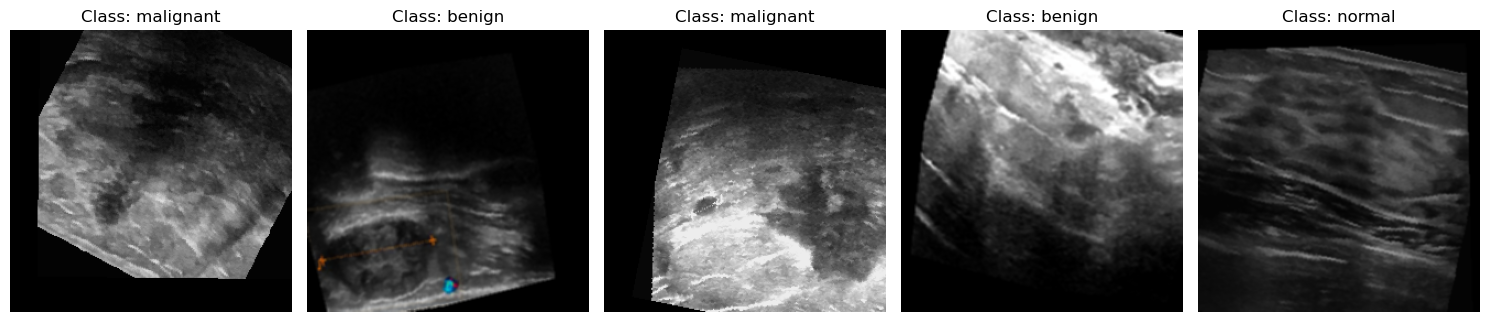

In [31]:
# Get a single batch from the DataLoader
train_batch, train_labels = next(iter(dataloaders['train']))  # Fetch first batch and labels

# Print batch information
print(f"Batch Shape: {train_batch.shape}")
print(f"Data Type: {train_batch.dtype}")
print(f"Min: {train_batch.min()}, Max: {train_batch.max()}")
print(f"Mean: {train_batch.mean():.4f}, Std: {train_batch.std():.4f}")
print(f"Number of batches in each split:")
print(f"- Train: {len(dataloaders['train'])}")
print(f"- Val: {len(dataloaders['val'])}")
print(f"- Test: {len(dataloaders['test'])}")

# Print class mapping
print("Class to Index Mapping:")
print(train_dataset.class_to_idx)

# Print class names in order
print("\nClass Names (in order of indices):")
print(train_dataset.classes)

# Count samples per class
class_counts = {class_name: 0 for class_name in train_dataset.classes}
for _, label in train_dataset:
    class_counts[train_dataset.classes[label]] += 1

print("\nSamples per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

def visualize_batch(dataloader, num_images=5):
    # Get batch of images and labels
    images, labels = next(iter(dataloader))
    images = images[:num_images]
    labels = labels[:num_images]
    
    # Get class names from the dataset
    class_names = dataloader.dataset.classes
    
    # Create a figure with subplots and show images
    plt.figure(figsize=(15, 4))
    
    for i in range(num_images):
        # Convert tensor to numpy and transpose to (H,W,C)
        img = images[i].numpy().transpose(1, 2, 0)
        
        # Denormalize image
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        gamma = 1.2
        img = np.power(img, gamma)
        print(f"Image stats - Min: {img.min():.3f}, Max: {img.max():.3f}, Mean: {img.mean():.3f}")
        # Create subplot
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f'Class: {class_names[labels[i]]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize a batch of images
visualize_batch(dataloaders['train'])



In [32]:
### Focal Loss ###
import torch.nn.functional as F
class FocalLoss(nn.Module):
    """
    Focal Loss for multi-class classification.
    It handles multi-class cases and the alpha parameter correctly.
    """
    def __init__(self, alpha=0.75, gamma=4.0, class_weights=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.class_weights = class_weights

    def forward(self, inputs, targets):
        # Convert inputs to probabilities
        probs = torch.softmax(inputs, dim=1)
        
        # Gather the probabilities of the true classes
        true_probs = probs.gather(1, targets.unsqueeze(1)).squeeze(1)
        
        # Compute the focal loss components
        focal_loss = -self.alpha * (1 - true_probs) ** self.gamma * torch.log(true_probs + 1e-8)
        
        if self.class_weights is not None:
            weights = self.class_weights[targets]
            focal_loss *= weights
        
        return focal_loss.mean()

In [33]:
### Dynamic sampling ###
from torch.utils.data import WeightedRandomSampler
def get_dynamic_sampler(dataset):
    # Count samples per class
    targets = np.array(dataset.targets)
    class_sample_count = np.array([np.sum(targets == t) for t in np.unique(targets)])
    # Inverse frequency for each class
    weight = 1. / class_sample_count
    # Assign weight to each sample
    samples_weight = np.array([weight[t] for t in targets])
    samples_weight = torch.from_numpy(samples_weight).float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)
    return sampler


dataloaders['train'] = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=get_dynamic_sampler(train_dataset), num_workers=2
)

print(dataloaders['train']) 
# Check if the dataloaders are working
for phase in ['train', 'val', 'test']:
    print(f"{phase.capitalize()} DataLoader:")
    for images, labels in dataloaders[phase]:
        print(f"  Batch size: {images.size(0)}, Labels(first batch): {labels}")
        break  
  

Train DataLoader:
  Batch size: 16, Labels(first batch): tensor([1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 2, 2, 0, 0, 0, 1])
Val DataLoader:
  Batch size: 16, Labels(first batch): tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Test DataLoader:
  Batch size: 16, Labels(first batch): tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [34]:
### Moldel Setup ###
from torchvision.models import resnet50 ,ResNet50_Weights
def setup_improved_model():
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    
    # Unfreeze more layers
    for param in list(model.parameters())[-60:]:
        param.requires_grad = True
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(2048, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(1024, num_classes)
    )
    return model.to(device)

# Initialize the model
model = setup_improved_model()

In [35]:
# Modify your training configuration
learning_rate = 0.0003  # Lower learning rate

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=0.02  # Increase weight decay
)

# One Cycle Policy
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=Epochs,
    steps_per_epoch=len(dataloaders['train']),
    pct_start=0.3,
    anneal_strategy='cos'
)

In [36]:
### Class weights ###
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F

# Get all training labels
all_labels = np.array([label for _, label in train_dataset])

# Compute initial class weights from all training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

weights = torch.tensor(class_weights, dtype=torch.float).to(device)

def update_class_weights(model, dataloader, device):
    model.eval()  # Ensure model is in eval mode
    confidences = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            confidences.append(probs)

    # Concatenate all confidence tensors
    confidences = torch.cat(confidences, dim=0)

    # Compute average confidence per class
    avg_confidence = confidences.mean(dim=0)

    # Inverse confidence weighting
    updated_weights = 1 / (avg_confidence + 1e-5)
    normalized_weights = updated_weights / updated_weights.sum()

    return normalized_weights.to(device)

In [37]:
### Define the Focal Loss function with class weights
# Modify your Focal Loss parameters
criterion = FocalLoss(
    alpha=0.75,  # Increase alpha for malignant class
    gamma=4.0,   # Increase gamma to focus more on hard examples
    class_weights=weights  # Keep your class weights
)

In [38]:
### Gradient Accumulation ###
accumulation_steps = 4  # Effective batch size = batch_size * accumulation_steps
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# In training loop:
for i, (inputs, labels) in enumerate(dataloaders['train']):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss = loss / accumulation_steps
    loss.backward()

    if (i + 1) % accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

        

In [39]:
### Test-time augmentation (TTA) function
def tta_predict(model, image, num_augments=5):
    model.eval()
    predictions = []
    
    # Original prediction
    with torch.no_grad():
        pred = model(image)
        predictions.append(pred)
    
    # Augmented predictions
    for _ in range(num_augments):
        aug_image = transforms_train(image)
        with torch.no_grad():
            pred = model(aug_image)
            predictions.append(pred)
    
    # Average predictions
    return torch.stack(predictions).mean(0)

In [40]:
# Model Ensemble
class EnsembleModel(nn.Module):
    def __init__(self, model_checkpoints):
        super().__init__()
        self.models = nn.ModuleList([
            setup_improved_model() for _ in range(len(model_checkpoints))
        ])
        for model, checkpoint in zip(self.models, model_checkpoints):
            model.load_state_dict(torch.load(checkpoint))
            
    def forward(self, x):
        outputs = [model(x) for model in self.models]
        return torch.mean(torch.stack(outputs), dim=0)

In [43]:
# Mixup Training
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [44]:
#Early stopping parameters
patience=20

In [45]:
### Early Stopping and Model Training Function

import time
import copy

def train_model(model, criterion, optimizer, dataloaders, num_epochs=Epochs, patience=patience, scheduler=scheduler):
    since = time.time()
    best_accuracy = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    epochs_no_improve = 0  

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_accuracy = running_corrects.double() / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_accuracy:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_accuracy'].append(epoch_accuracy.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_accuracy'].append(epoch_accuracy.item())

                if scheduler is not None:
                    if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                        scheduler.step(epoch_loss)
                    elif isinstance(scheduler, lr_scheduler.StepLR):
                        scheduler.step()

                # Early stopping
                if epoch_loss < best_val_loss:
                    best_val_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f'No improvement for {epochs_no_improve} epochs.')
                    print(f'Best val acc: {best_accuracy:.4f}')

                if epochs_no_improve >= patience:
                    print(f'Best val acc: {best_accuracy:.4f}')
                    print(f'Early stopping at epoch {epoch+1}')
                    model.load_state_dict(best_model_wts)
                    return model, history

                if epoch_accuracy > best_accuracy:
                    best_accuracy = epoch_accuracy
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print(f'New best accuracy: {best_accuracy:.4f}')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_accuracy:.4f}')

    model.load_state_dict(best_model_wts)
    return model, history

In [46]:
#Train model
model ,history = train_model(model, criterion, optimizer, dataloaders, num_epochs=Epochs , scheduler=scheduler)

Epoch 1/100
--------------------
train Loss: 0.3775 Acc: 0.3114
val Loss: 0.1676 Acc: 0.2821
New best accuracy: 0.2821
Epoch 2/100
--------------------
train Loss: 0.3873 Acc: 0.3040
val Loss: 0.1794 Acc: 0.2906
No improvement for 1 epochs.
Best val acc: 0.2821
New best accuracy: 0.2906
Epoch 3/100
--------------------
train Loss: 0.3450 Acc: 0.3407
val Loss: 0.1842 Acc: 0.2051
No improvement for 2 epochs.
Best val acc: 0.2906
Epoch 4/100
--------------------
train Loss: 0.3818 Acc: 0.3114
val Loss: 0.1914 Acc: 0.2991
No improvement for 3 epochs.
Best val acc: 0.2906
New best accuracy: 0.2991
Epoch 5/100
--------------------
train Loss: 0.3775 Acc: 0.3242
val Loss: 0.1799 Acc: 0.3504
No improvement for 4 epochs.
Best val acc: 0.2991
New best accuracy: 0.3504
Epoch 6/100
--------------------
train Loss: 0.3811 Acc: 0.3205
val Loss: 0.1793 Acc: 0.2906
No improvement for 5 epochs.
Best val acc: 0.3504
Epoch 7/100
--------------------
train Loss: 0.3722 Acc: 0.3205
val Loss: 0.1843 Acc: 0.

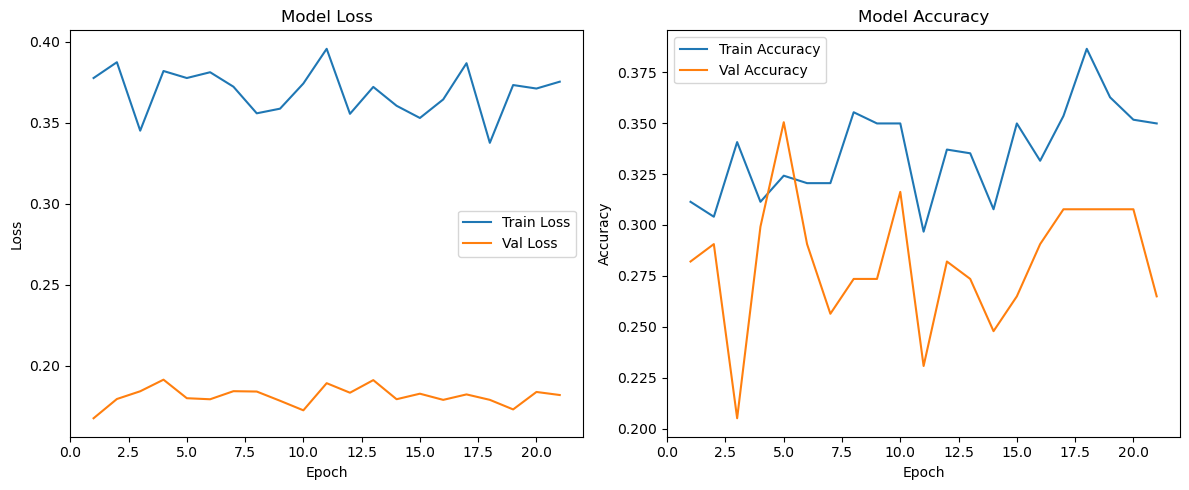

In [47]:
# Plot training and validation loss and accuracy from the training history

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [48]:
# Train multiple models with different seeds
models = []
for seed in [42, 123, 456, 789, 101]:
    torch.manual_seed(seed)
    model = setup_improved_model()
    trained_model, _ = train_model(model, criterion, optimizer, dataloaders)
    models.append(trained_model)

# Prediction with ensemble
def ensemble_predict(models, inputs):
    predictions = []
    for model in models:
        with torch.no_grad():
            pred = model(inputs)
            predictions.append(F.softmax(pred, dim=1))
    return torch.mean(torch.stack(predictions), dim=0)

Epoch 1/100
--------------------
train Loss: 0.3775 Acc: 0.3114
val Loss: 0.1676 Acc: 0.2821
New best accuracy: 0.2821
Epoch 2/100
--------------------
train Loss: 0.3873 Acc: 0.3040
val Loss: 0.1794 Acc: 0.2906
No improvement for 1 epochs.
Best val acc: 0.2821
New best accuracy: 0.2906
Epoch 3/100
--------------------
train Loss: 0.3450 Acc: 0.3407
val Loss: 0.1842 Acc: 0.2051
No improvement for 2 epochs.
Best val acc: 0.2906
Epoch 4/100
--------------------
train Loss: 0.3818 Acc: 0.3114
val Loss: 0.1914 Acc: 0.2991
No improvement for 3 epochs.
Best val acc: 0.2906
New best accuracy: 0.2991
Epoch 5/100
--------------------
train Loss: 0.3775 Acc: 0.3242
val Loss: 0.1799 Acc: 0.3504
No improvement for 4 epochs.
Best val acc: 0.2991
New best accuracy: 0.3504
Epoch 6/100
--------------------
train Loss: 0.3811 Acc: 0.3205
val Loss: 0.1793 Acc: 0.2906
No improvement for 5 epochs.
Best val acc: 0.3504
Epoch 7/100
--------------------
train Loss: 0.3722 Acc: 0.3205
val Loss: 0.1843 Acc: 0.

KeyboardInterrupt: 

In [49]:
#  Evaluate the Model on the Test Set
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions and labels
test_preds, test_labels = evaluate_model(model, dataloaders['test'])

# Calculate accuracy
test_acc = np.mean(test_preds == test_labels)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.1780


              precision    recall  f1-score   support

      benign       0.50      0.05      0.08        66
   malignant       0.33      0.03      0.06        32
      normal       0.16      0.85      0.26        20

    accuracy                           0.18       118
   macro avg       0.33      0.31      0.13       118
weighted avg       0.40      0.18      0.11       118



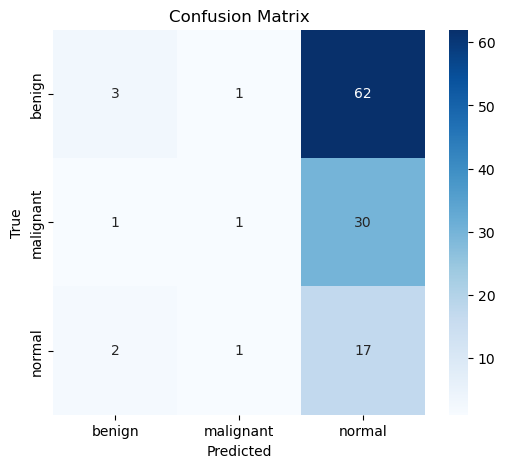

In [50]:
# Show a Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report
print(classification_report(test_labels, test_preds, target_names=train_dataset.classes))

# Plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def visualize_feature_maps(model, input_image):
    # Get intermediate feature maps
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # Register hooks
    model.layer4[-1].register_forward_hook(get_activation('features'))
    
    # Forward pass
    output = model(input_image)
    
    # Visualize features
    features = activation['features']
    plt.figure(figsize=(12, 8))
    for i in range(min(16, features.shape[1])):
        plt.subplot(4, 4, i+1)
        plt.imshow(features[0, i].cpu())
        plt.axis('off')
    plt.tight_layout()
    plt.show()